# Enron Email Dataset Analysis

As Enron Email Dataset contains data about Emails text contents and, with good use of analytics and Modelling with NLP to find insights and apply them for many applications. I was interested to work on Email Body text Analytics and hence picked this challenge. 

In [1]:
import pandas as pd
import re
import string

import spacy
NER = spacy.load('en_core_web_sm')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
stop_words.update(('so','this','when','it','many','so','cant','yes','no','these'))
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


!pip3 install en_core_web_sm
!python -m spacy download en
import nltk   
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import gensim 
from gensim import corpora
import pyLDAvis 
import pyLDAvis.gensim_models
from gensim.models.coherencemodel import CoherenceModel 

[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the full
pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-11-11 20:33:14.678829: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2021-11-11 20:33:14.678866: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mayur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
df = pd.read_csv('enron_test.csv',parse_dates=['Date', 'new_date'])

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
df.head()

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,From,To,Subject,content,new_date
0,2001-05-14 16:39:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),NaN,Here is our forecast\n\n,2001-05-14 23:39:00
1,2001-05-04 13:51:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Re:,Traveling to have a business meeting takes the...,2001-05-04 20:51:00
2,2000-10-18 03:00:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),Re: test,test successful. way to go!!!,2000-10-18 10:00:00
3,2000-10-23 06:13:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),NaN,"Randy,\n\n Can you send me a schedule of the s...",2000-10-23 13:13:00
4,2000-08-31 05:07:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),Re: Hello,Let's shoot for Tuesday at 11:45.,2000-08-31 12:07:00


## Data Understanding

In [4]:
df.describe()

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,From,To,Subject,content,new_date
count,1000,1000,995,698,1000,1000
unique,650,41,229,347,657,650
top,1979-12-31 16:00:00-08:00,frozenset({'phillip.allen@enron.com'}),frozenset({'ina.rangel@enron.com'}),Re:,"Bruce,\n\nThank you for your bid. I have deci...",1980-01-01 00:00:00
freq,5,946,66,53,2,5
first,NaN,NaN,NaN,NaN,NaN,1980-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2001-05-14 23:39:00


With Describe, we can see that there is high chance of Data Duplication as I can notice here, there are 657 Content unique from total of 1000 emails. This Dataset was spread over total of 650 days in total, with sender being total of 41 users.  

In [5]:
# Checking the data types to understand what each columns Series contains.
df.dtypes

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Date                object
From                object
To                  object
Subject             object
content             object
new_date    datetime64[ns]
dtype: object

Interestingly, there are 5 missing "To" receiver data, we need to dig more about that. Also we have 305 Subjects missing.As we are working with textual data, we can't impute any values here. We need to analyse what and why is that data missing.

In [6]:
#Checking for Missing values from the dataset.
df.isna().sum()

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Date          0
From          0
To            5
Subject     302
content       0
new_date      0
dtype: int64

In [7]:
# This explains the duplicated data as shown below, we have found similar content counted more than once.
content = df['content'].value_counts().index.tolist()
content_count = df['content'].value_counts().tolist()
DuplicatedData  = pd.DataFrame(data = {"Content":content,'Count':content_count})
DuplicatedData[DuplicatedData['Count']>1]

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Content,Count
0,"Bruce,\n\nThank you for your bid. I have deci...",2
1,vishal resigned today,2
2,"Tara, \n\n This note is documentation of my ap...",2
3,"Jim,\n\n Updated curves will be sent no later ...",2
4,---------------------- Forwarded by Phillip K ...,2
...,...,...
338,---------------------- Forwarded by Phillip K ...,2
339,11:15 today still works.,2
340,---------------------- Forwarded by Phillip K ...,2
341,"Kay,\n\n I will be down that weekend, but I am...",2


In [8]:
print(f"In total of {DuplicatedData[DuplicatedData['Count']>1].shape[0]} mail bodies were duplicatied more than once")

In total of 343 mail bodies were duplicatied more than once


C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
df[df['To'].isna()]

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,From,To,Subject,content,new_date
188,2000-05-01 03:56:00-07:00,frozenset({'phillip.allen@enron.com'}),NaN,Re: DSL- Installs,No one will be home on 5/11/00 to meet DSL ins...,2000-05-01 10:56:00
603,2000-12-13 08:35:00-08:00,frozenset({'messenger@ecm.bloomberg.com'}),NaN,Bloomberg Power Lines Report,Here is today's copy of Bloomberg Power Lines....,2000-12-13 16:35:00
781,2000-05-01 03:56:00-07:00,frozenset({'phillip.allen@enron.com'}),NaN,Re: DSL- Installs,No one will be home on 5/11/00 to meet DSL ins...,2000-05-01 10:56:00
873,2000-01-07 16:23:00-08:00,frozenset({'owner-strawbale@crest.org'}),NaN,NaN,<4DDE116DBCA1D3118B130080C840BAAD02CD53@ppims....,2000-01-08 00:23:00
885,2001-05-14 09:04:00-07:00,frozenset({'messenger@ecm.bloomberg.com'}),NaN,Bloomberg Power Lines Report,Here is today's copy of Bloomberg Power Lines....,2001-05-14 16:04:00


From the 5 Emails, I found out 2 seem to duplicated here,out of these 2 were sent from messengers, and 2 from phillip allen. I wanted to check more on the Subjects to understand how many emails where just replies to the original mails.

In [10]:
df['Subject'].value_counts().index.tolist()

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Re:',
 'Re: Resume',
 "Re: This morning's Commission meeting delayed",
 'Request from Steve Kean',
 'Westgate Proforma-Phillip Allen.xls',
 'Re: The Stage',
 'Re: (No Subject)',
 'New Notice from Transwestern Pipeline Co.',
 'Investment Structure',
 'Re: New Notice from Transwestern Pipeline Co.',
 'Nondeliverable mail',
 'Re: receipts',
 'Daily Report',
 'Re: Western Wholesale Activities - Gas & Power Conf. Call',
 'Re: Katy flatlands',
 'assoc. for west desk',
 'RE:',
 'Re: APEA - $228,204 hit',
 'RE: W basis quotes',
 'Priority List',
 're: apt. #2',
 'Maps',
 'Re: #30',
 'Western Strategy Session Materials',
 'Re: Buyout',
 'Alliance netback worksheet',
 'Consolidated positions: Issues & To Do list',
 'San Juan Index',
 'Re: FW: 2nd lien info. and private lien info - The Stage Coach\n Apartments, Phillip Allen',
 'Re: NGI access to eol',
 'approved trader list',
 'Re: insurance - the stage',
 "Re: FERC's Prospective Mitigation and Monitoring Plan for CA\n Wholesale Electric Marke

In [11]:
print(f"Here we go, we have {df[(df['Subject'].str.startswith(('Re:','re:'), na= False))].shape[0]} replied mails, as understood from the Subject body (Starting with RE: or re:). ") 

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Here we go, we have 377 replied mails, as understood from the Subject body (Starting with RE: or re:). 


In [12]:
# # This function is generally used from basic text clean purpose. Removes 
# def reg_clean(text,list_word=[]):
#     for words in text:
#         words = re.sub(r"", "", words)
#         list_word.append(words)
#     return list_word

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


I was wondering if I can find out Persons, Organization and Locations name out of the Email Body to understand. Which Names ,Organization and Location were mentioned the most. Making use of Spacy library,I tried collecting Noun forms in given respective lists to later plot a wordcloud for each.

In [13]:
Persons =[]
Organization = []
Location = []
for mail in df['content']:
    for words in NER(mail).ents:
        if words.label_ == "PERSON":
            Persons.append(words.text)
        if words.label_ == "GPE":
            Location.append(words.text)

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
#Clean Function is generally for cleaning numbers, punctuations, removing stopwords.
def clean(text):
    text = text.lower()
    text = re.sub('[^a-z ]+' , ' ', text)
    text = " ".join([word for word in text.split() if word not in stop_words and len(word)>1])
    return text 
import numpy as np

# Mostly when the content is a Forwarded, or a reply, They have unncessary data such as: 
#forwarded by to receiver from sender at time, cced by other senders.
#Using subject_cleaning function , I used subject to split the content body and remove the subject from content.
def subject_cleaning(text, splitter):
    if splitter != " " and splitter in text:
        return text.split(splitter)[1]
    else:
        return text

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
#Cleaning unnecessary words from the Person, Location.
Persons = [clean(person) for person in Persons]
Location = [clean(loc) for loc in Location]

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Updated the stopwords list as I did notice a lot of bad data from the content body which later affects the rest of the observation.

In [16]:
stop_words.update(('hou','ect','corp','na','llc','would','allen','phillip','per','use','get','com','http','need','week','free','www','email','include','please','asp','ee','question','last','mwa','make','comment','may','say','pm','thank','you','id','like','new','jhtml','send','day','month','year','go','try','let'))

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


As, we wanted to find out the most common words found from the email content. I am plotting as many words as possible using wordcloud.

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


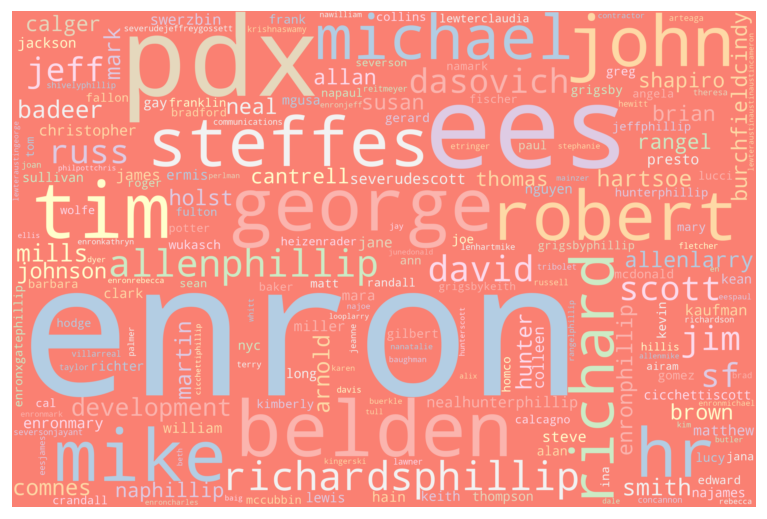

In [17]:
wordcloud_per = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = stop_words).generate(re.sub(r'(ect)','',"".join(Persons)))
figure(figsize=(8, 15), dpi=120)
plt.imshow(wordcloud_per, interpolation='bilinear')
plt.axis("off")
plt.show()

Ignoring Enron, as widely used company name, we can se Richard, George, Michael, John, Tim, Mike, Belden to be most commonly found names from the Email content.

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


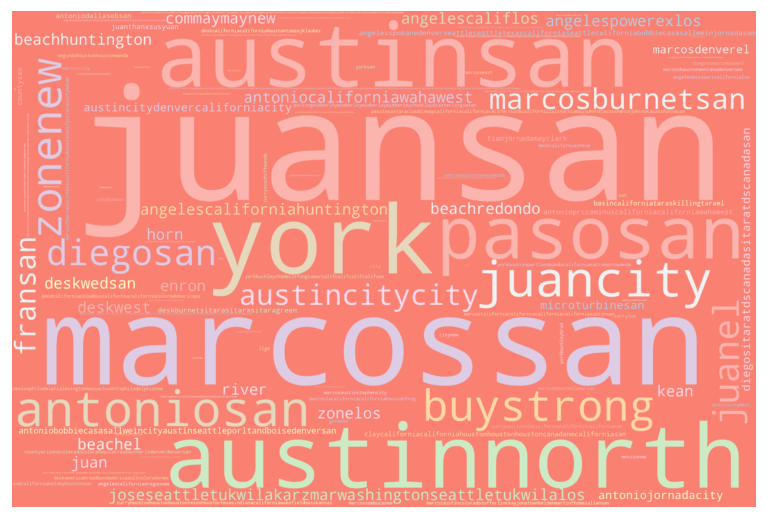

In [18]:
wordcloud_loc = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = stop_words).generate(re.sub(r'(ect)','',"".join(Location)))
figure(figsize=(8, 15), dpi=120)
plt.imshow(wordcloud_loc, interpolation='bilinear')
plt.axis("off")
plt.show()

Again ignoring Enron for the same reason, we can see that North Austin , Juan, San Diego, San Antonio, San Paso, San Marcos,California are the most commonly found locations from the Email Content.

## Data Preprocessing

As working with Email Content,I did realize I need to work on preprocessing and cleaning before I move on to Analysis, Observations, or Modelling. From cleaning the text using regex to Filtering all common company terms and weird spaces and newline formats from Content to creating more data from Timestamp to further using that from Activity analysis. I spent my time more on making sure I can clean the data as much as possible.

In [19]:
#Cleaning Subject
df['Subject'] = df['Subject'].fillna(' ')
df['Subject'] = df['Subject'].astype(str) 

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Cleaning Content
df['content'] = df[['content','Subject']].apply(lambda x: subject_cleaning(*x), axis = 1)
df['content'] = df['content'].map(lambda x:clean(x))

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
#Changing dtypes
# df['new_date'] = pd.to_datetime(df['new_date'])

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
df.head()

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,From,To,Subject,content,new_date
0,2001-05-14 16:39:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),,forecast,2001-05-14 23:39:00
1,2001-05-04 13:51:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Re:,traveling business meeting takes fun trip espe...,2001-05-04 20:51:00
2,2000-10-18 03:00:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),Re: test,test successful way,2000-10-18 10:00:00
3,2000-10-23 06:13:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),,randy schedule salary level everyone schedulin...,2000-10-23 13:13:00
4,2000-08-31 05:07:00-07:00,frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),Re: Hello,shoot tuesday,2000-08-31 12:07:00


In [23]:
#Cleaning From Column, Using regex, I picked emails Id in a clean format.
df['From']= df['From'].map(lambda x:"".join(re.findall(r"\'(.*?)\'",str(x))))

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
#Cleaning To Column, Collecting all email Id from the string.
df['To'] = df['To'].map(lambda x: ",".join(re.findall(r"\w+@\w+.\w+",str(x))))

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
df.head()

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,From,To,Subject,content,new_date
0,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,belden@enron.com,,forecast,2001-05-14 23:39:00
1,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,lavorato@enron.com,Re:,traveling business meeting takes fun trip espe...,2001-05-04 20:51:00
2,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,arsdall@enron.com,Re: test,test successful way,2000-10-18 10:00:00
3,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,gay@enron.com,,randy schedule salary level everyone schedulin...,2000-10-23 13:13:00
4,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,piper@enron.com,Re: Hello,shoot tuesday,2000-08-31 12:07:00


## Data Analytics

In [26]:
df['From'].value_counts().head()

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


phillip.allen@enron.com        946
critical.notice@enron.com        5
ina.rangel@enron.com             4
sarah.novosel@enron.com          2
messenger@ecm.bloomberg.com      2
Name: From, dtype: int64

Phillip Allen from Enron was mostly the Email Sender here, in total 946 mails where sent from Phillip Allen. 

In [27]:
#Check who was receiver with most number of mails received from the given Email content
df['To'].value_counts().head()

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rangel@enron.com              66
jsmith@austintx.com           60
stagecoachmama@hotmail.com    59
pallen70@hotmail.com          42
holst@enron.com               37
Name: To, dtype: int64

In [28]:
df[df['From'].str.contains('phillip.allen@enron.com')]['To'].value_counts().head()

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rangel@enron.com              66
jsmith@austintx.com           60
stagecoachmama@hotmail.com    59
pallen70@hotmail.com          42
holst@enron.com               37
Name: To, dtype: int64

These Emails where the majority Email receivers, where I noticed that "pallen70@hotmail.com" can be Phillip Allen's personal Email Id.Here I wanted to find how mails where shared between Phillip allen with his personal Email Id 

rangel@enron.com, jsmith@austintx.com, stagecoachmama@hotmail.com, pallen70@hotmail.com ,holst@enron.com

R Angel being the Email receiver with most email sent from Phillip allen.

In [29]:
df[(df['From'].str.contains("allen"))& (df['To'].str.contains("pallen70@hotmail.com"))].head(10)

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,From,To,Subject,content,new_date
18,2000-10-03 09:30:00-07:00,phillip.allen@enron.com,pallen70@hotmail.com,Westgate,,2000-10-03 16:30:00
26,2000-09-26 09:26:00-07:00,phillip.allen@enron.com,pallen70@hotmail.com,Investment Structure,structure typically structure limited partners...,2000-09-26 16:26:00
41,2000-09-19 09:35:00-07:00,phillip.allen@enron.com,pallen70@hotmail.com,Westgate Proforma-Phillip Allen.xls,enclosed preliminary proforma westgate propert...,2000-09-19 16:35:00
56,2000-09-08 05:30:00-07:00,phillip.allen@enron.com,pallen70@hotmail.com,Sagewood Town Homes,aware regan lehman lot developer entire lot du...,2000-09-08 12:30:00
57,2000-09-08 05:29:00-07:00,phillip.allen@enron.com,pallen70@hotmail.com,Westgate Proforma-Phillip Allen.xls,enclosed preliminary proforma westgate propert...,2000-09-08 12:29:00
58,2000-09-06 08:54:00-07:00,phillip.allen@enron.com,pallen70@hotmail.com,utilities roll,private mail msn hotmail hotmail share informa...,2000-09-06 15:54:00
96,2000-08-20 10:39:00-07:00,phillip.allen@enron.com,pallen70@hotmail.com,Daily Duties,working different apartments today listen diff...,2000-08-20 17:39:00
97,2000-08-20 10:39:00-07:00,phillip.allen@enron.com,pallen70@hotmail.com,Daily Report,bought today cost pd ck wal mart also ralph ap...,2000-08-20 17:39:00
98,2000-08-20 10:38:00-07:00,phillip.allen@enron.com,pallen70@hotmail.com,Daily Report,today one days wade pay fine take takes alot t...,2000-08-20 17:38:00
255,2000-02-04 09:09:00-08:00,phillip.allen@enron.com,pallen70@hotmail.com,,forwarded mary richards maryrichards hotmail c...,2000-02-04 17:09:00


In [30]:
len(df[(df['From'].str.contains("allen"))& (df['To'].str.contains("pallen70@hotmail.com"))])

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


42

We can see that, 42 Mails were sent by Phillip Allen to his may be personal Email pallen70@hotmail.com, where one email found was allen@enron.com and others where phillip.allen@enron.com

In [31]:
#Creating more data for Analysis
df['Day'] = df['new_date'].map(lambda x: x.day_name())
df['Month'] = df['new_date'].map(lambda x: x.month_name())
df['Hour'] = df['new_date'].map(lambda x: x.hour )

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Moving forward, we will observe how many emails were sent on daily , weekly, and monthly basis from a specific email sender.

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Enter sender's Email Id: 
This is the Email Activity for Phillip Allen over three graphs (Daily, Weekly, and Monthly Activity)


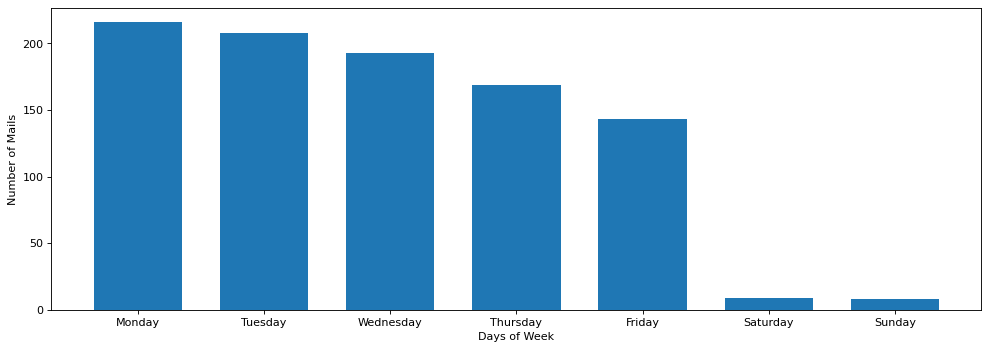

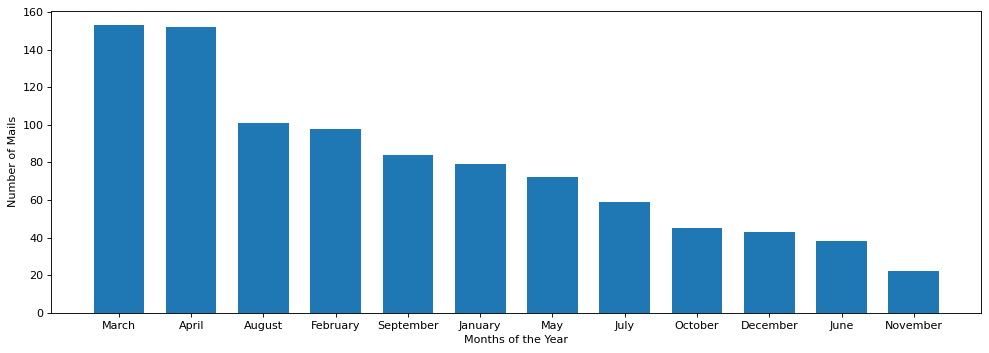

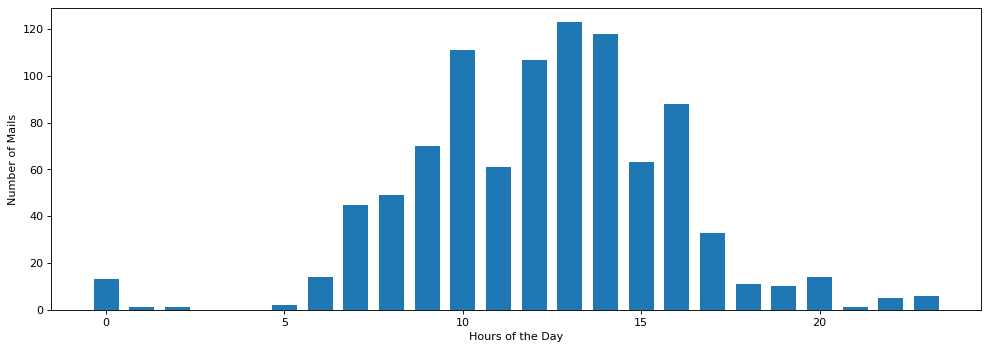

In [32]:
sender_email = input("Enter sender's Email Id: ")
def visualize(sender_email = "phillip.allen@enron.com"):
    figure(figsize=(15, 5), dpi=80)
    X_days = df[(df['From'] == sender_email)]['Day'].value_counts().index.tolist()
    Y_values = df[(df['From'] == sender_email)]['Day'].value_counts().tolist()
    plt.bar(X_days, Y_values, width=0.7, align='center')
    plt.xlabel('Days of Week')
    plt.ylabel('Number of Mails')
    plt.show() 
    
    figure(figsize=(15, 5), dpi=80)
    X_days = df[(df['From'] == sender_email)]['Month'].value_counts().index.tolist()
    Y_values = df[(df['From'] == sender_email)]['Month'].value_counts().tolist()
    plt.bar(X_days, Y_values, width=0.7, align='center')
    plt.xlabel('Months of the Year')
    plt.ylabel('Number of Mails')
    plt.show()
    
    figure(figsize=(15, 5), dpi=80)
    X_Hours = df[(df['From'] == sender_email)]['Hour'].value_counts().index.tolist()
    Y_values = df[(df['From'] == sender_email)]['Hour'].value_counts().tolist()
    plt.bar(X_Hours, Y_values, width=0.7, align='center')
    plt.xlabel('Hours of the Day')
    plt.ylabel('Number of Mails')
    plt.show()

    return None
if sender_email:
    print(f"This is the Email Activity for {sender_email} over three graphs (Daily, Weekly, and Monthly Activity)")
    visualize(sender_email)
else:
    print("This is the Email Activity for Phillip Allen over three graphs (Daily, Weekly, and Monthly Activity)")
    visualize()


In [33]:
df.head()

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,From,To,Subject,content,new_date,Day,Month,Hour
0,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,belden@enron.com,,forecast,2001-05-14 23:39:00,Monday,May,23
1,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,lavorato@enron.com,Re:,traveling business meeting takes fun trip espe...,2001-05-04 20:51:00,Friday,May,20
2,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,arsdall@enron.com,Re: test,test successful way,2000-10-18 10:00:00,Wednesday,October,10
3,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,gay@enron.com,,randy schedule salary level everyone schedulin...,2000-10-23 13:13:00,Monday,October,13
4,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,piper@enron.com,Re: Hello,shoot tuesday,2000-08-31 12:07:00,Thursday,August,12


## Use Cases
### Topic Modelling LDA

Along with Analytical Observation, I have created a statistical model to discover abstract “topics” that occur in a collection of documents. This Observation uses a collection of all words from the content, and finds words than can be collected under a similar topic. This way we can understand what all topics we can notice the content to catergorize them accordingly.

In [34]:
#Lemmatizing words to their noun form, to make better observation and remove repeatitive words.
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()
mail_list = df['content'].tolist()
lemma_mails = []
for mail in mail_list:
    lemma_mails.append([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(mail)])
print(lemma_mails)

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['forecast'], ['travel', 'business', 'meeting', 'take', 'fun', 'trip', 'especially', 'prepare', 'presentation', 'suggest', 'hold', 'business', 'plan', 'meeting', 'take', 'trip', 'without', 'formal', 'business', 'meeting', 'even', 'honest', 'opinion', 'whether', 'trip', 'even', 'desire', 'necessary', 'far', 'business', 'meeting', 'think', 'productive', 'stimulate', 'discussion', 'across', 'different', 'group', 'work', 'often', 'presenter', 'speaks', 'others', 'quiet', 'wait', 'turn', 'meeting', 'might', 'well', 'held', 'round', 'table', 'discussion', 'format', 'suggestion', 'austin', 'play', 'golf', 'rent', 'ski', 'boat', 'jet', 'ski', 'fly', 'somewhere', 'take', 'much', 'time'], ['test', 'successful', 'way'], ['randy', 'schedule', 'salary', 'level', 'everyone', 'schedule', 'group', 'plus', 'thought', 'change', 'make', 'patti', 'example'], ['shoot', 'tuesday'], ['greg', 'either', 'next', 'tuesday', 'thursday'], ['cc', 'follow', 'distribution', 'list', 'update', 'pallen', 'enron', 'mike

In [35]:
dictionary = corpora.Dictionary(lemma_mails)
doc_term_matrix = [dictionary.doc2bow(mail) for mail in lemma_mails]

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


By creating a LDA model, I wanted to check how many topics can the model create with better model validation, as model should have lower perplexity value and high value Coherence Value.

In [36]:
for i in range(3,9):
    LDA = gensim.models.ldamodel.LdaModel
    lda = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics = i, random_state= 100, passes = 10,iterations = 100)
    perplexity = lda.log_perplexity(doc_term_matrix)
    coherence_LDA = CoherenceModel(model = lda, texts= lemma_mails, dictionary= dictionary , coherence = 'c_v')
    coherence_val = coherence_LDA.get_coherence()
    print(f' For Number of Topics {i} -> Perplexity Value = {perplexity}, and Coherence Value = {coherence_val}')

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 For Number of Topics 3 -> Perplexity Value = -7.581614818661947, and Coherence Value = 0.3188790519942305
 For Number of Topics 4 -> Perplexity Value = -7.557493878811404, and Coherence Value = 0.32988074271264883
 For Number of Topics 5 -> Perplexity Value = -7.51992145447608, and Coherence Value = 0.29859149622142456
 For Number of Topics 6 -> Perplexity Value = -7.475692998412253, and Coherence Value = 0.4214681039130051
 For Number of Topics 7 -> Perplexity Value = -7.440810799424686, and Coherence Value = 0.4356108238574761
 For Number of Topics 8 -> Perplexity Value = -7.415137648470551, and Coherence Value = 0.492792102818179


In [37]:
LDA = gensim.models.ldamodel.LdaModel
lda = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics = 8, random_state= 100, passes = 10,iterations = 100)

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


After observing that 8 number of topics with better model validation values, we will take a look at how the topics are formed with the collection of words under each topic. We can see that, Topic 7 has collection of Loan and Real Estate Construction related words, Topic 5 has a collection of Meeting related mails.

In [38]:
# lda.show_topics(num_topics=8, num_words=6, log=False
for idx, topic in lda.show_topics(formatted=False, num_words= 15):
    print('Topic: {} \nWords: {}'.format(idx, '|'.join([w[0] for w in topic])))

Topic: 0 
Words: price|power|say|trader|megawatt|gas|high|bloomberg|weather|trade|trading|sell|low|today|energy
Topic: 1 
Words: project|property|plan|work|austin|set|know|take|anyone|list|site|look|position|lot|time
Topic: 2 
Words: image|gas|price|trade|basis|market|enron|specialist|yahoo|index|east|sr|time|utility|question
Topic: 3 
Words: item|ee|power|iso|enron|living|line|say|plant|outlook|front|plan|shopping|productid|lc
Topic: 4 
Words: enron|subject|gas|cc|forward|ee|call|thanks|also|time|receive|work|sent|mike|christi
Topic: 5 
Words: meeting|scott|buy|physical|start|date|forward|description|response|gas|hunter|shively|allan|severson|severude
Topic: 6 
Words: mail|see|time|net|call|shockwave|information|friday|today|want|work|know|reduction|meeting|issue
Topic: 7 
Words: loan|cost|construction|land|lot|improvement|fee|unit|cash|total|equity|builder|investment|value|amount


C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
pyLDAvis.enable_notebook(sort=True)
vis = pyLDAvis.gensim_models.prepare(lda, doc_term_matrix, dictionary)
pyLDAvis.display(vis)

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


After this, we can go into granularity of topics specifically made from phillip allen's contents. Also we can create Timeline charts to understand seasonal trends of each mail sender. How often a specific sender sends a mail,and who likely to send a mail on given days. A lot can be done after this. Along with these, we can map such emails into either bot or not a bot, spam or no spam, sentiment analysis on each mail to understand the what mood is the content written in. NLP is a vast topic with very different observations due to unstructured text data.

In [40]:
# stop_words.update(('would','allen','phillip','per','use','get','com','http','need','week','free','www','email','include','please','asp','ee','question','last','mwa','make','comment','may','say','pm','thank','you','id','like','new','jhtml','send','day','month','year','go','try','let'))

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
"""<-------------------------------------------------The End ------------------------------------------------------->""" 

C:\Users\mayur\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'<-------------------------------------------------The End ------------------------------------------------------->'